In [1]:
# %%
import warnings

warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

import STG3Net as MODEL


def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping


import anndata as ad


def get_data(config):
    count = pd.read_csv(
        "D:\\project\\datasets\\SC_ST_Data\\snRNAseq_brain\\GSE147747\\GSE147747_expr_raw_counts_table.tsv",
        sep="\t", index_col=0)

    meta = pd.read_csv("D:\\project\\datasets\\SC_ST_Data\\snRNAseq_brain\\GSE147747\\GSE147747_meta_table.tsv",
                       sep="\t",
                       index_col=0)

    adata_st_all = ad.AnnData(X=count.values)
    adata_st_all.obs.index = count.index
    adata_st_all.obs = meta.loc[adata_st_all.obs.index]
    adata_st_all.var.index = count.columns

    slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
                 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
                 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
                 '31A', '32A', '33A', '34A', '35A', ]

    result, mapping = mapping2int(slice_use)

    meta_slice = pd.read_csv(
        "D:\\project\\datasets\\SC_ST_Data\\snRNAseq_brain\\GSE147747\\data\\figures\\slicestable.tsv",
        index_col=0, sep="\t")
    slice_AP = [float(meta_slice.loc[s]['AP']) * 1000 for s in slice_use]
    slice_dist_micron = [-(slice_AP[i + 1] - slice_AP[i]) for i in range(len(slice_AP) - 1)]

    adata_st_all = adata_st_all[[s in slice_use for s in adata_st_all.obs.section_index.values]]
    sc.pp.filter_cells(adata_st_all, min_genes=1)

    adata_st_all.obsm['spatial'] = np.concatenate(
        (adata_st_all.obs['HE_X'].values.reshape(-1, 1), adata_st_all.obs['HE_Y'].values.reshape(-1, 1)), axis=1)

    for i, slice_id in enumerate(sorted(set(adata_st_all.obs.section_index.values))):
        adata_tmp = adata_st_all[adata_st_all.obs.section_index.values == slice_id]
        array_col = np.array([np.float32(loc.split("_")[1].split("x")[0]) for loc in adata_tmp.obs.index])
        if slice_id == '01A':
            array_col = array_col - 0.3
        array_row = np.array([np.float32(loc.split("_")[1].split("x")[1]) for loc in adata_tmp.obs.index])

        adata_tmp.obs['array_col'] = np.round(array_col)
        adata_tmp.obs['array_row'] = np.round(array_row)

        adata_tmp.obs['batch_name'] = slice_id
        adata_tmp.obs['slice_id'] = mapping[slice_id]

        adata_tmp.var_names_make_unique()
        # Remove mt-genes
        adata_tmp = adata_tmp[:, (np.array(~adata_tmp.var.index.str.startswith("mt-"))
                                  & np.array(~adata_tmp.var.index.str.startswith("MT-")))]
        adata_tmp.obs.index = adata_tmp.obs.index + "-slice%d" % i

        adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['ABA_parent'])]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if i == 0:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = slice_id
            adata.obs['proj_name'] = slice_id
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = slice_id

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + slice_id
    adata.layers['count'] = adata.X
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict


import harmonypy as hm


# %%
def compute_fscoreLISI(Tmp_adata, LT_key, BT_key, PD_key):
    LISI_batch_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[BT_key]], label_colnames=[BT_key])[:, 0]
    LISI_domain_norm = hm.compute_lisi(Tmp_adata.obsm[LT_key], Tmp_adata.obs[[PD_key]], label_colnames=[PD_key])[:, 0]

    LISI = 2 * (1 / LISI_domain_norm) * LISI_batch_norm / (1 / LISI_domain_norm + LISI_batch_norm)
    return LISI


In [2]:
with open('../Config/Config_MB.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

In [3]:
adata, graph_dict = get_data(config['data'])

In [4]:
num_cluster = 15
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [5]:
net.train(early_stop_epochs=100, random_seed=666)

Epoch 495 total loss=0.727 recon loss=0.550 tri loss=0.000 disc loss=3.422:  50%|████▉     | 496/1000 [00:12<00:11, 45.14it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Epoch 545 total loss=0.914 recon loss=0.576 tri loss=0.335 disc loss=3.432:  55%|█████▍    | 546/1000 [00:34<00:26, 16.96it/s]

fitting ...
  |======================================================================| 100%


Epoch 595 total loss=0.902 recon loss=0.566 tri loss=0.328 disc loss=3.411:  60%|█████▉    | 597/1000 [00:52<00:21, 18.76it/s]

fitting ...
  |======================================================================| 100%


Epoch 645 total loss=0.891 recon loss=0.560 tri loss=0.317 disc loss=3.408:  65%|██████▍   | 647/1000 [01:18<00:23, 15.33it/s]

fitting ...
  |======================================================================| 100%


Epoch 695 total loss=0.894 recon loss=0.561 tri loss=0.320 disc loss=3.414:  70%|██████▉   | 696/1000 [01:36<00:16, 18.44it/s]

fitting ...
  |======================================================================| 100%


Epoch 745 total loss=0.880 recon loss=0.557 tri loss=0.300 disc loss=3.403:  75%|███████▍  | 746/1000 [01:57<00:14, 17.42it/s]

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=0.883 recon loss=0.556 tri loss=0.309 disc loss=3.396:  80%|███████▉  | 796/1000 [02:15<00:10, 18.98it/s]

fitting ...
  |======================================================================| 100%


Epoch 845 total loss=0.864 recon loss=0.553 tri loss=0.275 disc loss=3.394:  85%|████████▍ | 847/1000 [02:33<00:07, 19.46it/s]

fitting ...
  |======================================================================| 100%


Epoch 895 total loss=0.874 recon loss=0.556 tri loss=0.290 disc loss=3.402:  90%|████████▉ | 896/1000 [02:54<00:06, 17.20it/s]

fitting ...
  |======================================================================| 100%


Epoch 945 total loss=0.878 recon loss=0.557 tri loss=0.300 disc loss=3.388:  95%|█████████▍| 947/1000 [03:12<00:02, 19.24it/s]

fitting ...
  |======================================================================| 100%


Epoch 990 total loss=0.870 recon loss=0.555 tri loss=0.284 disc loss=3.393:  99%|█████████▉| 990/1000 [03:29<00:02,  4.73it/s]

Stop trainning because of loss convergence


In [6]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
print(adata)

AnnData object with n_obs × n_vars = 17086 × 3000
    obs: 'section_index', 'stereo_ML', 'stereo_DV', 'stereo_AP', 'HE_X', 'HE_Y', 'ABA_acronym', 'ABA_name', 'ABA_parent', 'nuclei_segmented', 'spot_radius', 'passed_QC', 'cluster_id', 'cluster_name', 'n_genes', 'array_col', 'array_row', 'batch_name', 'slice_id', 'proj_name', 'batch', 'G3STNet_Domain'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'latent'
    layers: 'count'


In [7]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


In [8]:
sub_adata = adata[~pd.isnull(adata.obs['ABA_parent'])]
ARI = ari_score(sub_adata.obs['ABA_parent'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")

total ARI:0.4460477092469308


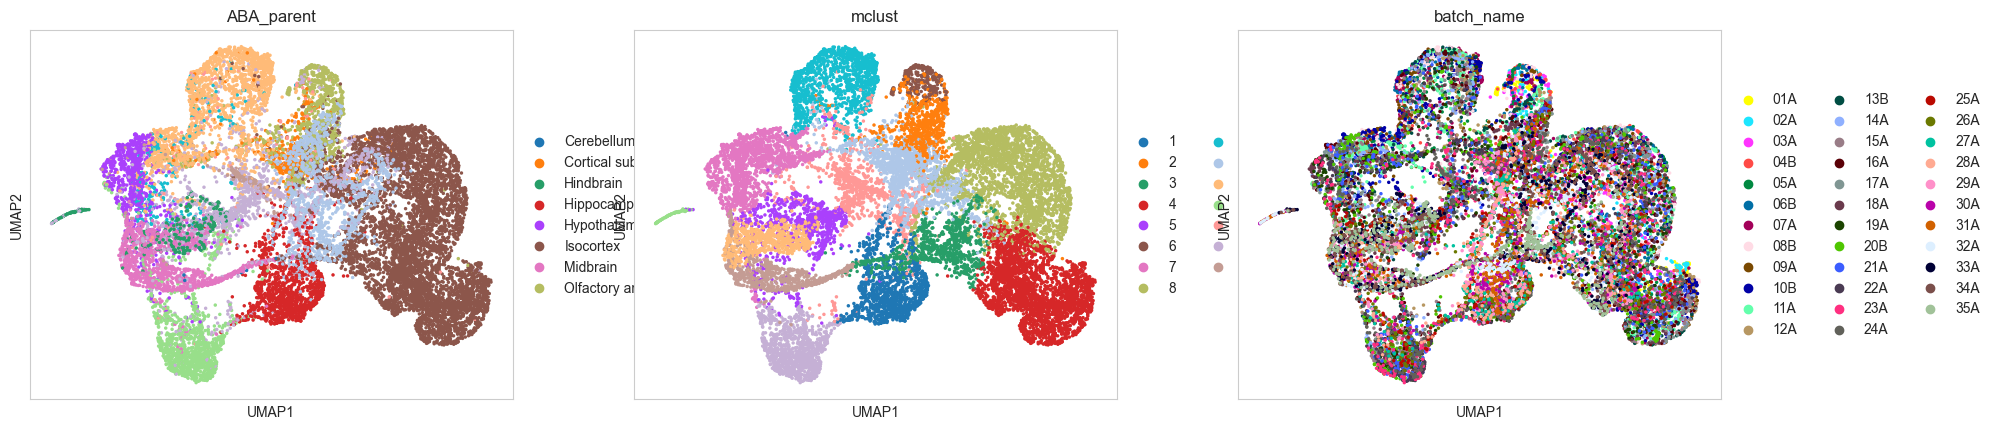

In [9]:
# %%
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['ABA_parent', 'mclust', 'batch_name'], show=True, size=25, save=False)

In [10]:
sub_adata = adata[~pd.isnull(adata.obs['ABA_parent'])]
NMI = MODEL.compute_NMI(sub_adata, f'ABA_parent', f'mclust')
print(f"total NMI:{NMI}")

total NMI:0.5842245572084314


In [11]:
sub_adata = adata[~pd.isnull(adata.obs['ABA_parent'])]
HOM = MODEL.compute_HOM(sub_adata, f'ABA_parent', f'mclust')
print(f"total HOM:{HOM}")

total HOM:0.625998272182158


In [12]:
sub_adata = adata[~pd.isnull(adata.obs['ABA_parent'])]
COM = MODEL.compute_COM(sub_adata, f'ABA_parent', f'mclust')
print(f"total COM:{COM}")

total COM:0.547677306645524


In [13]:
sub_adata = adata[~pd.isnull(adata.obs['ABA_parent'])]
CHAOS = MODEL.compute_CHAOS(sub_adata, f'mclust')
print(f"total CHAOS:{CHAOS}")

total CHAOS:0.01950601568979955


In [14]:
sub_adata = adata[~pd.isnull(adata.obs['ABA_parent'])]
PAS = MODEL.compute_PAS(sub_adata, f'mclust')
print(f"total PAS:{PAS}")

total PAS:0.795388036989348


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
             '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
             '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
             '31A', '32A', '33A', '34A', '35A', ]
BT_key = 'batch_name'
GT_key = 'ABA_parent'
PD_key = 'mclust'
LT_key = 'latent'

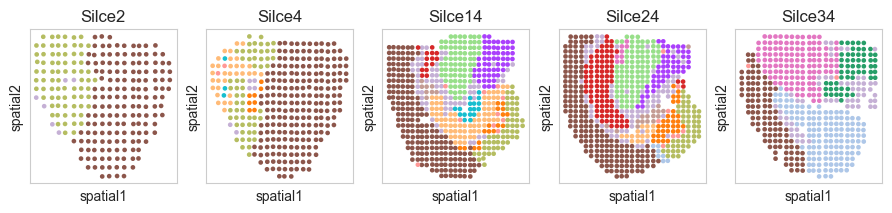

In [24]:
plt.figure(figsize=(11, 2))
k = 1
for i in [1, 3, 13, 23, 33]:
    adata_tmp = adata[adata.obs[BT_key] == slice_use[i]]
    ax = plt.subplot(1, 5, k)
    sc.pl.embedding(adata_tmp, basis='spatial', color=GT_key, s=45, ax=ax, show=False, legend_loc=False)
    # sc.pl.embedding(adata_list[i], basis='spatial', color='spatial_domain', s=45, ax=ax, show=False)
    plt.title(f'Silce{i + 1}')
    k += 1

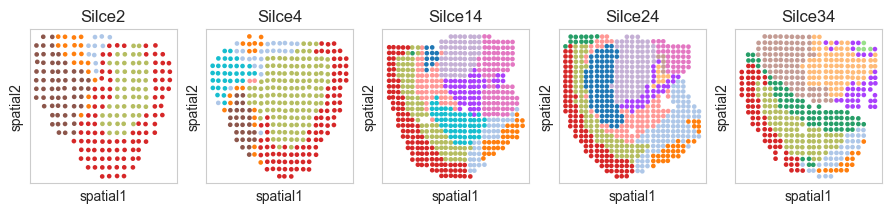

In [25]:
plt.figure(figsize=(11, 2))
k = 1
for i in [1, 3, 13, 23, 33]:
    adata_tmp = adata[adata.obs[BT_key] == slice_use[i]]
    ax = plt.subplot(1, 5, k)
    sc.pl.embedding(adata_tmp, basis='spatial', color=PD_key, s=45, ax=ax, show=False, legend_loc=False)
    # sc.pl.embedding(adata_list[i], basis='spatial', color='spatial_domain', s=45, ax=ax, show=False)
    plt.title(f'Silce{i + 1}')
    k += 1

In [26]:
find_slice = ['11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
              '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A', ]

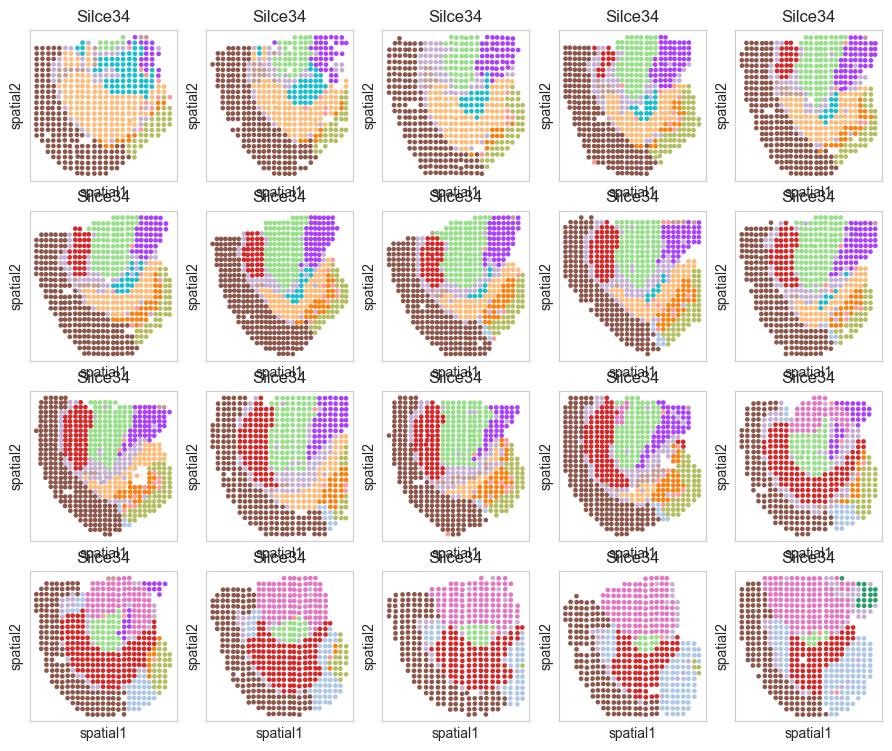

In [27]:
plt.figure(figsize=(11, 16))
k = 1
for slice_id, slice_name in enumerate(find_slice):
    adata_tmp = adata[adata.obs[BT_key] == find_slice[slice_id]]
    ax = plt.subplot(7, 5, k)
    sc.pl.embedding(adata_tmp, basis='spatial', color=GT_key, s=45, ax=ax, show=False, legend_loc=False)
    # sc.pl.embedding(adata_list[i], basis='spatial', color='spatial_domain', s=45, ax=ax, show=False)
    plt.title(f'Silce{i + 1}')
    k += 1

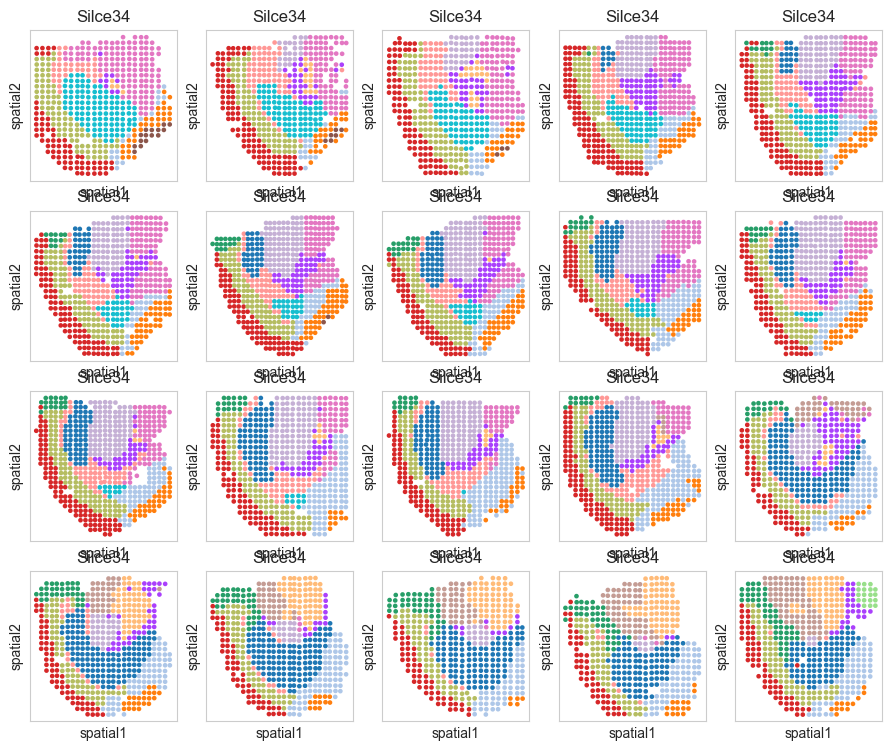

In [28]:
plt.figure(figsize=(11, 16))
k = 1
for slice_id, slice_name in enumerate(find_slice):
    adata_tmp = adata[adata.obs[BT_key] == find_slice[slice_id]]
    ax = plt.subplot(7, 5, k)
    sc.pl.embedding(adata_tmp, basis='spatial', color=PD_key, s=45, ax=ax, show=False, legend_loc=False)
    # sc.pl.embedding(adata_list[i], basis='spatial', color='spatial_domain', s=45, ax=ax, show=False)
    plt.title(f'Silce{i + 1}')
    k += 1

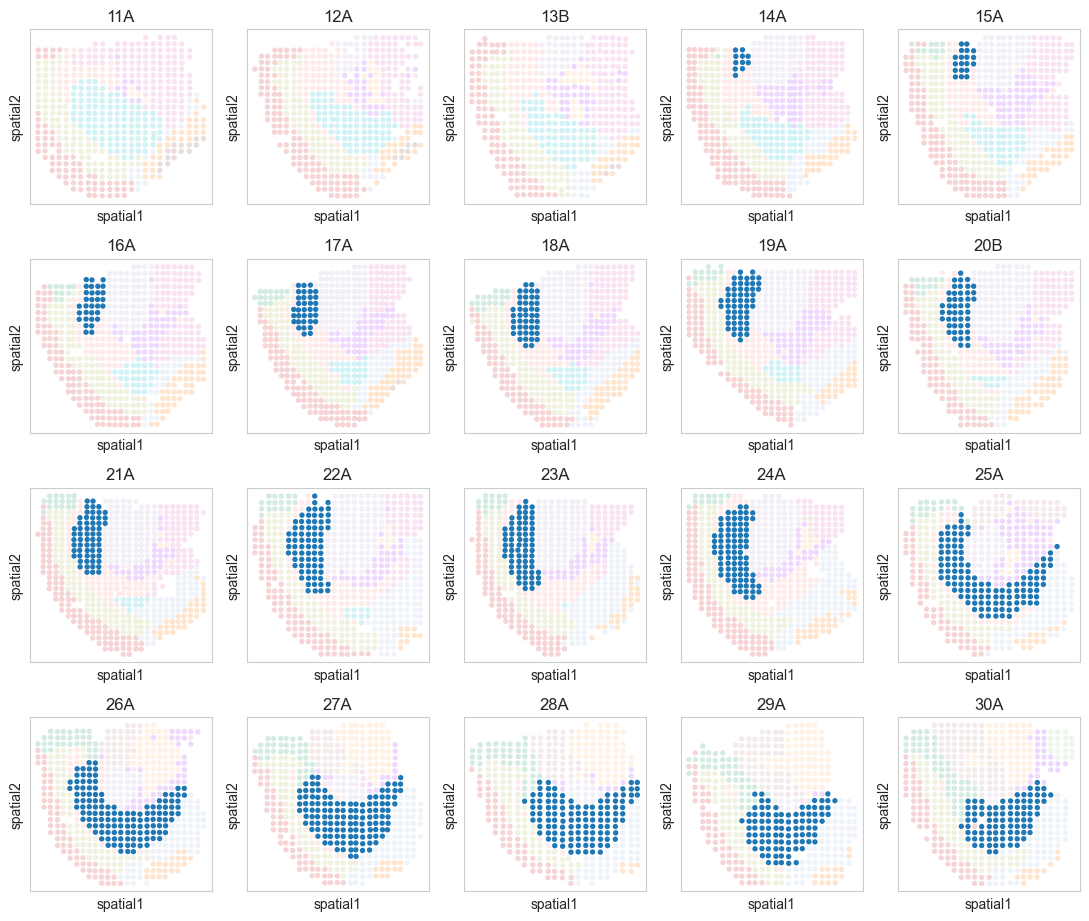

In [29]:
# sub = adata[adata.obs['mclust'] == 3]
# sc.pl.spatial(sub, spot_size=30, color='mclust', ax=axes[i], legend_loc=None, show=False)
# find_slice = slice_use

sub = adata[adata.obs['mclust'] == 1]
subnon = adata[adata.obs['mclust'] != 1]
plt.figure(figsize=(11, 16))
k = 1
for slice_id, slice_name in enumerate(find_slice):
    adata_tmp = sub[sub.obs[BT_key] == find_slice[slice_id]]
    ax = plt.subplot(7, 5, k)
    sc.pl.embedding(adata_tmp, basis='spatial', color=PD_key, s=60, ax=ax, show=False, legend_loc=False,alpha=1)
    
    
    adata_tmp = subnon[subnon.obs[BT_key] == find_slice[slice_id]]
    ax = plt.subplot(7, 5, k)
    sc.pl.embedding(adata_tmp, basis='spatial', color=PD_key, s=60, ax=ax, show=False, legend_loc=False, alpha=0.2)
    # sc.pl.embedding(adata_list[i], basis='spatial', color='spatial_domain', s=45, ax=ax, show=False)
    plt.title(f'{slice_name}')
    k += 1
plt.tight_layout()

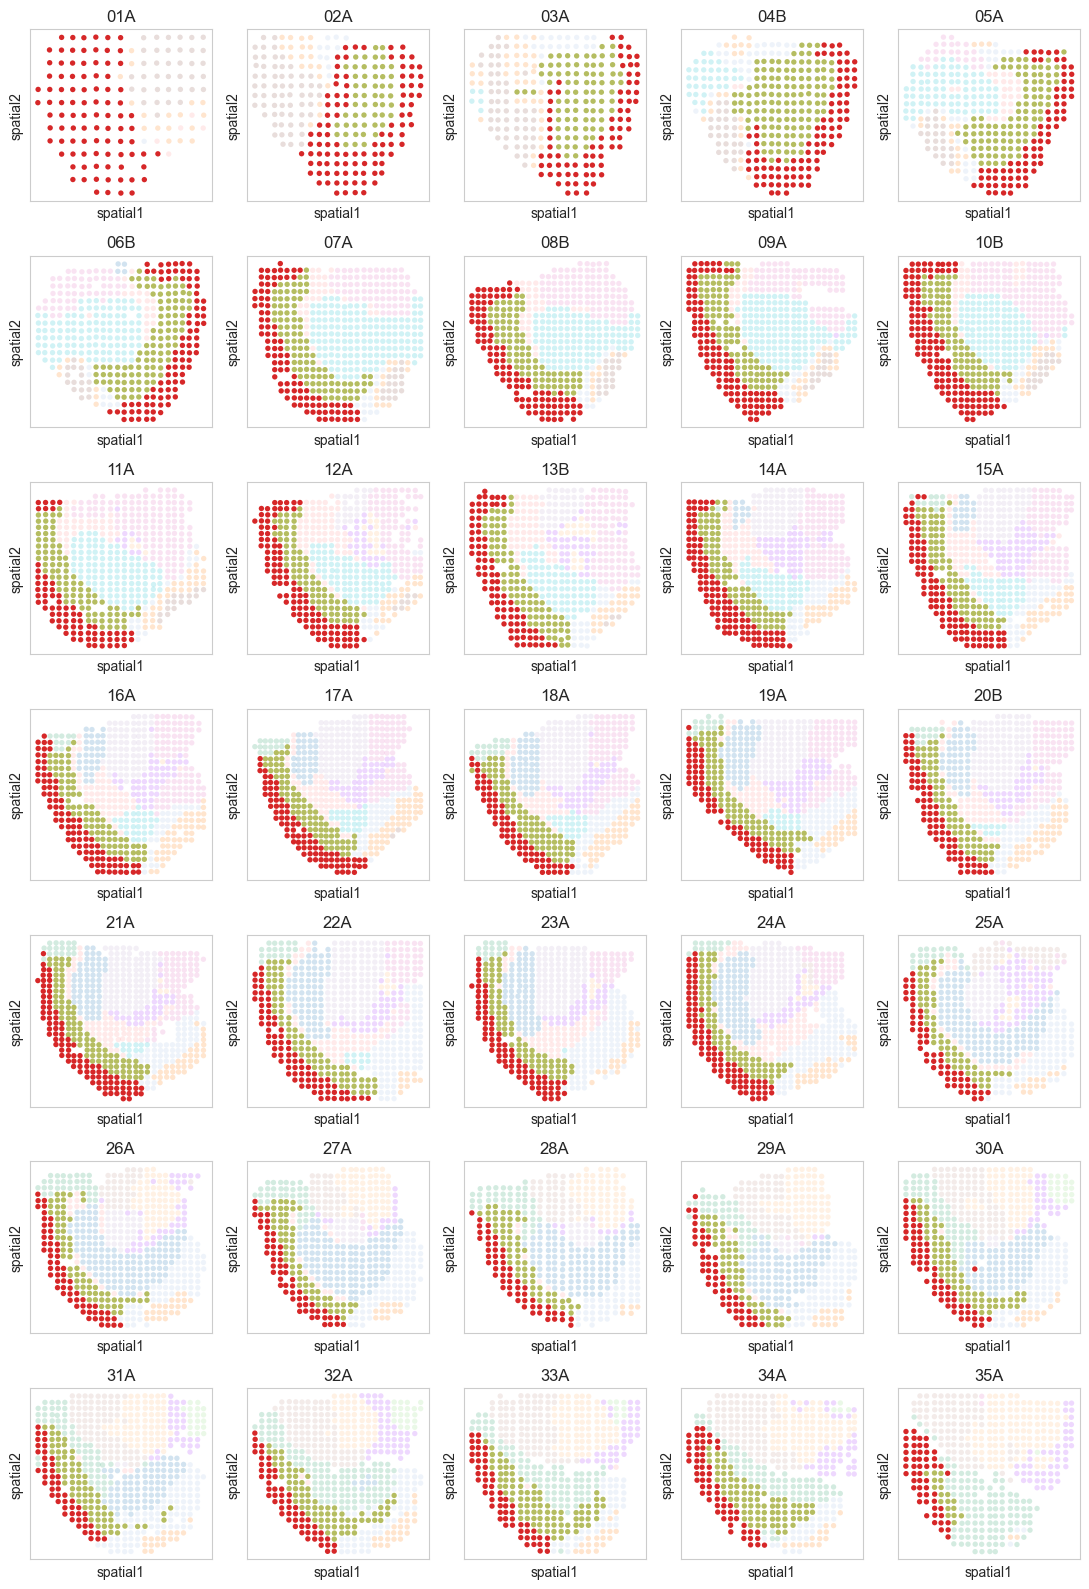

In [30]:
landmark1 = 8 
landmark2 = 4 
sub1 = adata[adata.obs['mclust'] == landmark1 ]
sub2 = adata[adata.obs['mclust'] == landmark2 ]
subnon = adata[adata.obs['mclust'] != landmark1]
subnon = subnon[subnon.obs['mclust'] != landmark2]
# sub = adata[adata.obs['mclust'] == 3]
# sc.pl.spatial(sub, spot_size=30, color='mclust', ax=axes[i], legend_loc=None, show=False)
# find_slice = slice_use
plt.figure(figsize=(11, 16))
k = 1
for slice_id, slice_name in enumerate(slice_use):
    adata_tmp = sub1[sub1.obs[BT_key] == slice_use[slice_id]]
    ax = plt.subplot(7, 5, k)
    sc.pl.embedding(adata_tmp, basis='spatial', color=PD_key, s=
    60, ax=ax, show=False, legend_loc=False, alpha=1)
    adata_tmp = sub2[sub2.obs[BT_key] == slice_use[slice_id]]
    sc.pl.embedding(adata_tmp, basis='spatial', color=PD_key, s=60, ax=ax, show=False, legend_loc=False, alpha=1)

    adata_tmp = subnon[subnon.obs[BT_key] == slice_use[slice_id]]
    ax = plt.subplot(7, 5, k)
    sc.pl.embedding(adata_tmp, basis='spatial', color=PD_key, s=60, ax=ax, show=False, legend_loc=False, alpha=0.2)
    # sc.pl.embedding(adata_list[i], basis='spatial', color='spatial_domain', s=45, ax=ax, show=False)
    plt.title(f'{slice_name}')
    k += 1
plt.tight_layout()